# Preprocessing

In [ ]:
import pandas as pd
import os
import openai
import math
import numpy as np
from gensim import matutils
import gensim.downloader
import time
import requests
from sklearn.model_selection import ParameterGrid
import statistics
import wandb
openai.api_key = openai.api_key_path="GPT3.txt"
wandb.login()

In [2]:
word_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
word_vectors.similarity('table', 'spain')

0.15602754

In [ ]:
# read csv dataset
df = pd.read_csv('Data/crawled_metaphors_selected_three_examples.csv', sep=";", index_col=0)
df_non_metaphoric = pd.read_csv('Data/non_metaphoric_examples.csv', sep=";")
df.head()

In [4]:
# how many different unique combinations of source and target
combinations = df.groupby(['Source Domain', 'Target Domain']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
combinations.head()

,Source Domain,Target Domain,counts
38,destruction,intoxication,4
129,size,amount,4
108,plants,beliefs,4
53,goal,success,4
6,areas,subjects,4


In [5]:
print("Number of target domains in VUA non-metaphoric:",len(df_non_metaphoric['Target Domain'].unique()))
print("Number of target domains in Metaphor List:",len(df['Target Domain'].unique()))
print("Number of source domains in Metaphor List:",len(df['Source Domain'].unique()))

Number of target domains in VUA non-metaphoric: 47
Number of target domains in Metaphor List: 91
Number of source domains in Metaphor List: 94


In [6]:
# split combinations randomly into train of size 40 and test set
train = combinations.sample(n=40, random_state=1)
test = combinations.drop(train.index)
print(len(train), len(test))
test

40 113


,Source Domain,Target Domain,counts
38,destruction,intoxication,4
129,size,amount,4
108,plants,beliefs,4
53,goal,success,4
6,areas,subjects,4
...,...,...,...
97,object,ideas,2
65,insanity,strong emotion,2
14,burden,intoxication,2
143,up,rational,2


In [7]:
# overlap in source domains between test and train
s_test=test['Source Domain'].unique()
s_train=train['Source Domain'].unique()
# how many source domains are in both sets
print("Source domain overlap train/test:",len(set(s_test).intersection(s_train)))
t_test = test['Target Domain'].unique()
t_train = train['Target Domain'].unique()
# how many target domains are in both sets
print("Target domain overlap train/test:",len(set(t_test).intersection(t_train)))

Source domain overlap train/test: 11
Target domain overlap train/test: 15


In [ ]:
# create train, val, and test tests 
train_df = pd.DataFrame(columns=["Source Domain", "Target Domain", "Title", "Metaphor", "Example"])
for i, row in train.iterrows():
    samples = df[(df["Source Domain"]==row["Source Domain"]) & (df["Target Domain"]==row["Target Domain"])] 
    train_df = train_df.append(samples.sample(n=min(3, len(samples)), random_state=1))

test_df = pd.DataFrame(columns=["Source Domain", "Target Domain", "Title", "Metaphor", "Example"])
valid_df = pd.DataFrame(columns=["Source Domain", "Target Domain", "Title", "Metaphor", "Example"])
for i, row in test.iterrows():
    samples = df[(df["Source Domain"]==row["Source Domain"]) & (df["Target Domain"]==row["Target Domain"])] 
    # split into samples for test and val; 1 sample for val, 2 for test
    test_samples = samples.sample(n=min(2, len(samples)), random_state=1)
    test_df = test_df.append(test_samples)
    valid_df = valid_df.append(samples.drop(test_samples.index))
valid_df.head()


In [ ]:
# distribute non-metaphoric samples across train, val, and test
train_df = train_df.append(df_non_metaphoric[:15])
valid_df = valid_df.append(df_non_metaphoric[15:30])
test_df = test_df.append(df_non_metaphoric[30:])

In [10]:
print("Lenght of train: ", len(train_df))
print("Lenght of valid: ", len(valid_df))
print("Lenght of test: ", len(test_df))

Lenght of train:  132
Lenght of valid:  120
Lenght of test:  244


## LCC Dataset for Additional Evaluation

In [11]:
LCC_df=pd.read_csv('Data/LCC_Metaphor_Dataset.small/en_small.csv', sep=";", index_col=0)
LCC_es_df=pd.read_csv('Data/LCC_Metaphor_Dataset.small/es_small.csv', sep=";", index_col=0)
LCC_df.head()

,Example,Source Domain,Target Domain
0,"So, you advocate for the ability to deny peopl...","['ABYSS', 'DISEASE']",POVERTY
1,"I found few things wrong with ""Law,"" written b...",['LIGHT'],WEALTH
2,"I, personally, do not see people who ""are born...","['PHYSICAL_LOCATION', 'PHYSICAL_LOCATION']",WEALTH
3,"Now if you ""eliminate those who already have t...","['ABYSS', 'ABYSS', 'NATURAL_PHYSICAL_FORCE', '...",POVERTY
4,The NBS report makes it quite clear that with ...,"['MACHINE', 'ABYSS', 'ABYSS']",POVERTY


In [12]:
# how many different target domains are in LCC_df
print("Number of Target Domains in LCC small:", len(LCC_df["Target Domain"].unique()))
print("Number of Target Domains in LCC small Spanish:", len(LCC_es_df["Target Domain"].unique()))

Number of Target Domains in LCC small: 30
Number of Target Domains in LCC small Spanish: 11


In [13]:
# print all target domains in LCC small es 
print(LCC_es_df["Target Domain"].unique())

['TAXATION' 'POVERTY' 'MONEY' 'WEALTH' 'TAXPAYERS' 'DEBT' 'TAXES'
 'ELECTIONS' 'BUREAUCRACY' 'GOVERNMENT' 'DEMOCRACY']


In [14]:
source_domains_LCC=LCC_df["Source Domain"].unique()
source_domains_LCC_es=LCC_es_df["Source Domain"].unique()
from ast import literal_eval
for i in range(len(source_domains_LCC)):
    source_domains_LCC[i]=set(literal_eval(source_domains_LCC[i]))
for i in range(len(source_domains_LCC_es)):
    source_domains_LCC_es[i]=set(literal_eval(source_domains_LCC_es[i]))

source_domains_LCC[0]


{'ABYSS', 'DISEASE'}

In [15]:
# a joined set of all source domains in LCC
source_domains_LCC_set=set()
source_domains_LCC_set_es=set()
for i in range(len(source_domains_LCC)):
    source_domains_LCC_set=source_domains_LCC_set.union(source_domains_LCC[i])
for i in range(len(source_domains_LCC_es)):
    source_domains_LCC_set_es=source_domains_LCC_set_es.union(source_domains_LCC_es[i])
print("Number of Source Domains in LCC small:", len(source_domains_LCC_set))
print("Number of Source Domains in LCC small Spanish:", len(source_domains_LCC_set_es))

Number of Source Domains in LCC small: 101
Number of Source Domains in LCC small Spanish: 101


In [16]:
# create df of 300 samples from LCC, 10 per target domain
LCC_df_300 = pd.DataFrame(columns=["Source Domain", "Target Domain", "Example"])
for i in range(len(LCC_df["Target Domain"].unique())):
    samples = LCC_df[LCC_df["Target Domain"]==LCC_df["Target Domain"].unique()[i]] 
    LCC_df_300 = LCC_df_300.append(samples.sample(n=min(10, len(samples)), random_state=144))
duplicates=LCC_df_300.duplicated(subset=["Example"]).sum()
print("Number of duplicates in LCC_df_300:", duplicates)
# number of source domains in LCC_df_300
source_domains_LCC_300=set()
for i in range(len(LCC_df_300["Source Domain"].unique())):
    source_domains_LCC_300=source_domains_LCC_300.union(set(literal_eval(LCC_df_300["Source Domain"].unique()[i])))
print("Number of Source Domains in LCC_df_300:", len(source_domains_LCC_300))
print("Length of LCC_df_300:", len(LCC_df_300))

Number of duplicates in LCC_df_300: 0
Number of Source Domains in LCC_df_300: 90
Length of LCC_df_300: 284


In [17]:
# create df of 110 samples from LCC es, 10 per target domain
LCC_es_df_110 = pd.DataFrame(columns=["Source Domain", "Target Domain", "Example"])
for i in range(len(LCC_es_df["Target Domain"].unique())):
    samples = LCC_es_df[LCC_es_df["Target Domain"]==LCC_es_df["Target Domain"].unique()[i]] 
    LCC_es_df_110 = LCC_es_df_110.append(samples.sample(n=min(10, len(samples)), random_state=5))
duplicates=LCC_es_df_110.duplicated(subset=["Example"]).sum()
print("Number of duplicates in LCC_es_df_110:", duplicates)
# number of source domains in LCC_es_df_110
source_domains_LCC_es_110=set()
for i in range(len(LCC_es_df_110["Source Domain"].unique())):
    source_domains_LCC_es_110=source_domains_LCC_es_110.union(set(literal_eval(LCC_es_df_110["Source Domain"].unique()[i])))
print("Number of Source Domains in LCC_es_df_110:", len(source_domains_LCC_es_110))
print("Length of LCC_es_df_110:", len(LCC_es_df_110))


Number of duplicates in LCC_es_df_110: 0
Number of Source Domains in LCC_es_df_110: 67
Length of LCC_es_df_110: 110


In [ ]:
# rewrite target domain in lower case
for i in range(len(LCC_df_300["Target Domain"])):
    LCC_df_300["Target Domain"].iloc[i]=LCC_df_300["Target Domain"].iloc[i].lower()
LCC_df_300.reset_index(drop=True, inplace=True)
LCC_df_300.head()

In [ ]:
# rewrite target domain in lower case
for i in range(len(LCC_es_df_110["Target Domain"])):
    LCC_es_df_110["Target Domain"].iloc[i]=LCC_es_df_110["Target Domain"].iloc[i].lower()
LCC_es_df_110.reset_index(drop=True, inplace=True)
LCC_es_df_110.head()

# Prompt Creation

In [20]:
def create_source_prompt(row):
    prompt="Extract the conceptual metaphor from the following sentence:\n"
    prompt+="Sentence: "+row['Example']+"\n"
    prompt+="Target Domain: "+str(row['Target Domain'])+"\n"
    prompt+="Source Domain:"
    completion=str(row['Source Domain'])
    return prompt, completion

def create_target_prompt(row):
    prompt = "Extract the conceptual metaphor from the following sentence:\n"
    prompt+="Sentence: "+row['Example']+"\n"
    prompt+="Source Domain: "+str(row['Source Domain'])+"\n"
    prompt+="Target Domain:"
    completion = str(row['Target Domain'])
    return prompt, completion

def create_full_prompt(row):
    prompt = "Extract the conceptual metaphor from the following sentence:\n"
    prompt+="Sentence: "+row['Example']+"\n"
    completion = "Target Domain: "+str(row['Target Domain'])+"\n"
    completion+="Source Domain: "+str(row['Source Domain'])
    return prompt, completion

In [22]:
# create source prompts
list_of_source_prompts_train = []
list_of_source_completions_train = []
list_of_source_prompts_test = []
list_of_source_completions_test = []
list_of_source_prompts_valid = []
list_of_source_completions_valid = []
list_of_source_prompts_LCC = []
list_of_source_completions_LCC = []
list_of_source_prompts_LCC_es = []
list_of_source_completions_LCC_es = []



for i, row in train_df.iterrows():
    list_of_source_prompts_train.append(create_source_prompt(row)[0])
    list_of_source_completions_train.append(create_source_prompt(row)[1])

for i, row in test_df.iterrows():
    list_of_source_prompts_test.append(create_source_prompt(row)[0])
    list_of_source_completions_test.append(create_source_prompt(row)[1])

for i, row in valid_df.iterrows():
    list_of_source_prompts_valid.append(create_source_prompt(row)[0])
    list_of_source_completions_valid.append(create_source_prompt(row)[1])
    
for i, row in LCC_df_300.iterrows():
    list_of_source_prompts_LCC.append(create_source_prompt(row)[0])
    list_of_source_completions_LCC.append(create_source_prompt(row)[1])

for i, row in LCC_es_df_110.iterrows():
    list_of_source_prompts_LCC_es.append(create_source_prompt(row)[0])
    list_of_source_completions_LCC_es.append(create_source_prompt(row)[1])
    
print("Prompt:", list_of_source_prompts_train[2])
print("Completion:", list_of_source_completions_train[2])

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: He recovered his hopes for a peace on earth.
Target Domain: hope
Source Domain:
Completion: possessions


In [23]:
# print prompt and completion for train side by side
index=-3
print("Prompt:", list_of_source_prompts_train[index])
print("Completion:", list_of_source_completions_train[index])

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: That's not my artwork on there, that's my little niece's artwork.
Target Domain: artwork
Source Domain:
Completion: not metaphoric


In [24]:
print("Prompt:", list_of_source_prompts_LCC[2])
print("Completion:", list_of_source_completions_LCC[2])

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: What is great about this resource is that it targets every possible area and route of poverty, rather than focusing on the traditional case studies of African poverty.
Target Domain: poverty
Source Domain:
Completion: ['JOURNEY']


In [25]:
# create full prompts
list_of_full_prompts_train = []
list_of_full_completions_train = []
list_of_full_prompts_test = []
list_of_full_completions_test = []
list_of_full_prompts_valid = []
list_of_full_completions_valid = []
list_of_full_prompts_LCC = []
list_of_full_completions_LCC = []
list_of_full_prompts_LCC_es = []
list_of_full_completions_LCC_es = []


for i, row in train_df.iterrows():
    list_of_full_prompts_train.append(create_full_prompt(row)[0])
    list_of_full_completions_train.append(create_full_prompt(row)[1])
for i, row in test_df.iterrows():
    list_of_full_prompts_test.append(create_full_prompt(row)[0])
    list_of_full_completions_test.append(create_full_prompt(row)[1])
for i, row in valid_df.iterrows():
    list_of_full_prompts_valid.append(create_full_prompt(row)[0])
    list_of_full_completions_valid.append(create_full_prompt(row)[1])
for i, row in LCC_df_300.iterrows():
    list_of_full_prompts_LCC.append(create_full_prompt(row)[0])
    list_of_full_completions_LCC.append(create_full_prompt(row)[1])
for i, row in LCC_es_df_110.iterrows():
    list_of_full_prompts_LCC_es.append(create_full_prompt(row)[0])
    list_of_full_completions_LCC_es.append(create_full_prompt(row)[1])
print("Prompt:", list_of_full_prompts_train[2])
print("Completion:", list_of_full_completions_train[2])

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: He recovered his hopes for a peace on earth.

Completion: Target Domain: hope
Source Domain: possessions


In [26]:
def create_fewshot_prompts(prompts_train, completions_train, prompts_test, completions_test, train_indices, extra_def):
    prompts = []
    completions = []
    train_prompt = ""
    if extra_def:
        train_prompt = 'In cognitive linguistics, conceptual metaphor, or cognitive metaphor, refers to the understanding of one idea, or conceptual domain, in terms of another. An example of this is the understanding of quantity in terms of directionality (e.g. "the price of peace is rising") or the understanding of time in terms of money (e.g. "I spent time at work today"). This idea, and a detailed examination of the underlying processes, was first extensively explored by George Lakoff and Mark Johnson in their work Metaphors We Live By in 1980.\n'
    for i in train_indices:
        train_prompt+=prompts_train[i]+" "+completions_train[i]+"\n"
    for i in range(len(prompts_test)):
        prompts.append(train_prompt+prompts_test[i])
        completions.append(completions_test[i])
    return prompts, completions


# additional prompt variant for step by step reasoning generations
def create_reasoning_prompts(prompts_test, completions_test):
    prompts = []
    completions = []
    train_prompt = '''Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: He recovered his hopes for a peace on earth.
Target Domain: hope
Reasoning: In the sentence above, the hopes are recovered. Recovering has a basic physical sentence, that is, getting back an object that belonged to you previously. Thus, hopes are talked about as possessions or physical objects. 
Source Domain: possessions

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence:  He finally found the key to the problem.
Target Domain: problem
Reasoning: The problem has a key, thus is a container that can be opened. 
Source Domain: container

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: You have to weigh the pros and cons.
Target Domain: comparison
Reasoning: In the sentence above, pros and cons are being compared. Instead of using the abstract word compare, the sentence uses the verb “to weight” usually used to describe measuring the weight of physical objects. Here, however, arguments, thus, non-physical entities, are being measures.
Source Domain: measuring weight 

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: the contagion of democratic ideas
Target Domain: belief
Reasoning: In the sentence above, ideas are described as something that is contagious, like a disease. 
Source Domain: disease

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: Follow your reasoning where it takes you.
Target Domain: logic
Reasoning: In the above sentence, logic refers to reasoning. Reasoning is described as something that you can follow, just like a path in the physical world.
Source Domain: path

Prompt: Extract the conceptual metaphor from the following sentence:
Sentence: But he said, don't wash it I wanna wear it.
Target Domain: washing
Reasoning: Washing is used in a literal sense and no metaphoric transfer is taking place.
Source Domain: not metaphoric\n\n'''
    for i in range(len(prompts_test)):
        # replace Source Domain with Reasoning in prompts_test[i]
        p_test=prompts_test[i].replace("Source Domain", "Reasoning")
        prompts.append(train_prompt+p_test)
        completions.append(completions_test[i])
    return prompts, completions
    

In [27]:
train_indices=[0,15,30,-1]
prompts, completions = create_fewshot_prompts(prompts_train = list_of_source_prompts_train, completions_train = list_of_source_completions_train, 
                prompts_test = list_of_source_prompts_valid, completions_test = list_of_source_completions_valid, train_indices=train_indices, extra_def=True)
print(len(prompts))

120


In [28]:
print(prompts[5])
print(completions[5])

In cognitive linguistics, conceptual metaphor, or cognitive metaphor, refers to the understanding of one idea, or conceptual domain, in terms of another. An example of this is the understanding of quantity in terms of directionality (e.g. "the price of peace is rising") or the understanding of time in terms of money (e.g. "I spent time at work today"). This idea, and a detailed examination of the underlying processes, was first extensively explored by George Lakoff and Mark Johnson in their work Metaphors We Live By in 1980.
Extract the conceptual metaphor from the following sentence:
Sentence: I've lost all hope of a solution.
Target Domain: hope
Source Domain: possessions
Extract the conceptual metaphor from the following sentence:
Sentence: Time heals all wounds.
Target Domain: time
Source Domain: changer
Extract the conceptual metaphor from the following sentence:
Sentence: He's really high.
Target Domain: euphoria
Source Domain: up
Extract the conceptual metaphor from the followin

In [26]:
# testing that GPT3 works
GPT3_completions=[]
for p in prompts[:5]:
     c = openai.Completion.create(
             model="text-davinci-002",
             prompt=p,
             max_tokens=14,
             temperature=0
         )
     GPT3_completions.append(c)
df_results = valid_df.copy().reset_index()
# append GPT3_completions to df_results [trainings_units:len(GPT3_completions)]
if len(GPT3_completions)>0:
    for i in range(len(GPT3_completions)):
        df_results.loc[i, 'GPT3 Source Completion'] = GPT3_completions[i].choices[0].text
    df_results[:len(GPT3_completions)][["Target Domain", "Source Domain","GPT3 Source Completion", "Example"]]

# Eval Methods

In [29]:
# compute the average similarity between the GPT3 completion and the source domain
def compute_embedding_similarity(df_results, task_type):
    '''
    df_results: dataframe containing the GPT3 completions
    result_samples: number of samples to be evaluated
    '''
    for i in range(len(df_results)):
        if task_type == "Source":
            gold = df_results.loc[i, 'Source Domain']
        elif task_type == "Target":
            gold = df_results.loc[i, 'Target Domain']
        elif task_type == "Finetuned":
            gold = df_results.loc[i, 'completion'].strip()
            gold = gold[:gold.rfind("END")].strip()
        predicted = df_results.loc[i, 'GPT3 Completion'].strip()
        # check if predicted or gold is multiple words
        if "-" in predicted:
            predicted = predicted.replace("-", " ")
        try: 
            if len(predicted.split()) > 1:
                predicted = matutils.unitvec(word_vectors.get_mean_vector(keys=predicted.split()))
            else:
                predicted = word_vectors.get_vector(predicted, norm=True)
            if len(gold.split()) > 1:
                #print(gold)
                gold = matutils.unitvec(word_vectors.get_mean_vector(keys=gold.split()))
            else:
                gold = word_vectors.get_vector(gold, norm=True)
            similarity = np.dot(predicted, gold)
        except:
            print("Error in computing embedding similarity for example: ", predicted, gold)
            similarity = 0
        df_results.loc[i, 'embedding_sim'] = similarity
    mean = df_results['embedding_sim'].mean()
    std = df_results['embedding_sim'].std()
    return mean, std, df_results

In [30]:
def query_resource_for_similarity(resource, gold_standard, prediction):
  response = requests.get("http://kgvec2go.org/rest/get-similarity/"+resource+"/"+gold_standard+"/"+prediction)
  if "result" in response.json():
    sim = response.json()["result"]
  else: 
    sim = 0
  
  return sim

def query_resource_related_concepts(resource, gold_standard):
  concepts = []
  response = requests.get("http://kgvec2go.org/rest/closest-concepts/"+resource+"/10/"+gold_standard)
  if "result" in response.json():
    for concept in response.json()["result"]: 
      concepts.append(str(concept["concept"]))
  else: 
    concepts =[] 
  
  return concepts


def tuple_KB_similarity(gold_standard, prediction): 
  similarities = []

  similarities.extend([query_resource_for_similarity("alod", gold_standard, prediction)] if query_resource_for_similarity("alod", gold_standard, prediction) > 0 else [])
  similarities.extend([query_resource_for_similarity("dbpedia", gold_standard, prediction)] if query_resource_for_similarity("dbpedia", gold_standard, prediction) > 0 else [])
  similarities.extend([query_resource_for_similarity("wiktionary", gold_standard, prediction)] if query_resource_for_similarity("wiktionary", gold_standard, prediction) > 0 else [])
  similarities.extend([query_resource_for_similarity("wordnet", gold_standard, prediction)] if query_resource_for_similarity("wordnet", gold_standard, prediction) > 0 else [])

  if len(similarities) > 0: 
    average_sim = statistics.mean(similarities)
  else: 
    average_sim = 0 

  return average_sim

def check_closest_concepts(gold_standard, prediction): 
  close = False
  concepts = []

  concepts.extend(query_resource_related_concepts("alod", gold_standard) if len(query_resource_related_concepts("alod", gold_standard)) > 0 else [])
  concepts.extend(query_resource_related_concepts("dbpedia", gold_standard) if len(query_resource_related_concepts("dbpedia", gold_standard)) > 0 else [])
  concepts.extend(query_resource_related_concepts("wiktionary", gold_standard) if len(query_resource_related_concepts("wiktionary", gold_standard)) > 0 else [])

  for concept in concepts: 
    if prediction in concept: 
      close = True
  
  return close

def compute_KB_similarity(df_results, task_type):
    '''
    df_results: dataframe containing the GPT3 completions
    result_samples: number of samples to be evaluated
    '''
    for i in range(len(df_results)):
        if task_type == "Source":
            gold = df_results.loc[i, 'Source Domain']
        elif task_type == "Target":
            gold = df_results.loc[i, 'Target Domain']
        elif task_type == "Finetuned":
            gold = df_results.loc[i, 'completion'].strip()
            # remove "END" token
            gold = gold[:gold.rfind("END")].strip()
        predicted = df_results.loc[i, 'GPT3 Completion'].strip()
        # use tuple_KB_similarity to compute the similarity between the gold and the predicted
        if predicted == gold:
          similarity = 1
        else:
          similarity = tuple_KB_similarity(gold, predicted)
        df_results.loc[i, 'KB_similarity'] = similarity
    mean = df_results['KB_similarity'].mean()
    std = df_results['KB_similarity'].std()
    return mean, std, df_results

In [31]:
def evaluate(df_results, task_type):
    mean_em, std_em, df_results = compute_embedding_similarity(df_results, task_type)
    print("Mean similarityc embeddings: ", mean_em)
    print("Standard deviation embeddings: ", std_em)

    mean_KB, std_KB, df_results = compute_KB_similarity(df_results, task_type)
    print("Mean similarity KB: ", mean_KB)
    print("Standard deviation KB: ", std_KB)
    
    return mean_em, std_em, mean_KB, std_KB, df_results


# Prompt Tuning

In [32]:
# this is currently specific to the task of predicting the source domain

def get_GPT3_completions(train_indices, eval_set, temperature, model, result_samples, extra_def=False, reasoning=False, debug=False):
    '''
    train_indices: indices of the examples to be used for training
    test: True if evaluation is on test set, False if evaluation is on validation set
    temperature: temperature of the GPT3 model
    model: GPT3 model to be used for evaluation
    result_samples: number of samples to be evaluated
    extra_def: True if extra definition is to be added to the beginning of the prompt
    '''

    if eval_set == "test":
        prompts_test = list_of_source_prompts_test
        completions_test = list_of_source_completions_test
    elif eval_set == "valid":
        prompts_test = list_of_source_prompts_valid
        completions_test = list_of_source_completions_valid
    elif eval_set == "LCC":
        prompts_test = list_of_source_prompts_LCC
        completions_test = list_of_source_completions_LCC
    elif eval_set == "LCC_es":
        prompts_test = list_of_source_prompts_LCC_es
        completions_test = list_of_source_completions_LCC_es

    if not reasoning:
        prompts, completions = create_fewshot_prompts(prompts_train = list_of_source_prompts_train, completions_train = list_of_source_completions_train, 
                    prompts_test = prompts_test, completions_test = completions_test, train_indices=train_indices, extra_def=extra_def)
    else:
        prompts, completions = create_reasoning_prompts(prompts_test=prompts_test, completions_test=completions_test)
   
    GPT3_completions=[]
    for i, p in enumerate(prompts[:result_samples]):
        if debug:
            print("Prompt", i)
            print(p)
        else:
            c = openai.Completion.create(
                    model=model,
                    prompt=p,
                    max_tokens=100,
                    temperature=temperature
                )
            GPT3_completions.append(c)
            # wait to avoid rate limit
            time.sleep(3)
    
    # append GPT3_completions to df_results 
    if debug == False:
        if eval_set=="test":
            df_results = test_df.copy().reset_index()
        elif eval_set=="valid":
            df_results = valid_df.copy().reset_index()
        elif eval_set=="LCC":
            df_results = LCC_df_300.copy().reset_index()
        elif eval_set=="LCC_es":
            df_results = LCC_es_df_110.copy().reset_index()
        for i in range(len(GPT3_completions)):
            df_results.loc[i, 'GPT3 Completion'] = GPT3_completions[i].choices[0].text
        return df_results[:len(GPT3_completions)][["Target Domain", "Source Domain","GPT3 Completion", "Example"]]

In [34]:
best_indices=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, -1]
get_GPT3_completions(train_indices=best_indices, eval_set="test", temperature=0, model="davinci", result_samples=2, extra_def=False, reasoning=False, debug=True)


Prompt 0
Extract the conceptual metaphor from the following sentence:
Sentence: I've lost all hope of a solution.
Target Domain: hope
Source Domain: possessions
Extract the conceptual metaphor from the following sentence:
Sentence: Even in backruptcy he managed to hang onto his car collection.
Target Domain: possession
Source Domain: holding
Extract the conceptual metaphor from the following sentence:
Sentence: A tigress in bed.
Target Domain: lust
Source Domain: animal
Extract the conceptual metaphor from the following sentence:
Sentence: He's really high.
Target Domain: euphoria
Source Domain: up
Extract the conceptual metaphor from the following sentence:
Sentence: We were made for each other.
Target Domain: love
Source Domain: part-whole
Extract the conceptual metaphor from the following sentence:
Sentence: Many theories sprang up out of the fertile soil of his discoveries.
Target Domain: theories
Source Domain: beings
Extract the conceptual metaphor from the following sentence:
Se

In [52]:
len(list_of_source_completions_train)

132

In [ ]:
# define training parameters 
result_samples = 999 # 999 for all
model = "text-curie-001" # or "text-davinci-002"
train_indices = [
    [0, -1], [3, -2], [6, -3],
    [0, 10, 20, -1], [3, 13, 23, -2], [6, 16, 26, -3],
    [0, 10, 20, 30, 40, -1], [3, 13, 23, 33, 43, -2], [6, 16, 26, 36, 46, -3],
    [0, 10, 20, 30, 40, 50, 60, -1], [3, 13, 23, 33, 43, 53, 63, -2], [6, 16, 26, 36, 46, 56, 66, -3],
    [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, -1], [3, 13, 23, 33, 43, 53, 63, 73, 83, 93, 103,-2], [6, 16, 26, 36, 46, 56, 66, 76, 86, 96, 106, -3]
    ]
#train_indices = [[0,15,30,45,-1]] # just for testing purposes
group="gridsearch" 

param_grid = {'temperature':[0], 'eval_set':["valid"], 'extra_def':[False], 'model':[model], 'train_indices': train_indices} #"text-curie-001" for faster/cheaper model
param_grid = list(ParameterGrid(param_grid))
print("Number of parameter combinations: ", len(param_grid), "\n")
print(param_grid)
scores_em = []
scores_KB = []

for i, params in enumerate(param_grid):
    print("Parameter combination ", i+1, "/", len(param_grid))
    if i+1 <= 11: # >11 before
        print("Parameters: ", params, "\n")
        run_name=params["eval_set"]+"_"+params['model'][5:]+"_temp-"+str(params['temperature'])+"_"+str(params['train_indices'])+"_("+str(len(params['train_indices']))+"-train-samples)"+"_def-"+str(params['extra_def'])
        # prompt 
        df_results = get_GPT3_completions(params["train_indices"], eval_set=params["eval_set"], temperature=params['temperature'], model=params['model'], result_samples=result_samples, extra_def=params['extra_def'])
        # evaluate 
        mean_em, std_em, mean_KB, std_KB, df_results = evaluate(df_results, "Source")
        run_name+="_embscore-"+str(round(mean_em, 2))[2:]
        run_name+="_KBscore-"+str(round(mean_KB, 2))[2:]
        scores_em.append(mean_em)
        scores_KB.append(mean_KB)

        config={
            "model": params['model'],
            "temperature": params['temperature'],
            "train_indices": params['train_indices'],
            "train_samples": len(params['train_indices']),
            "extra_def": params['extra_def'],
            "eval_set": params['eval_set'],
        }


        with wandb.init(project="Metaphors", config=config, group=group):
            wandb.log({"mean_em": mean_em, "std_em": std_em, "mean_KB": mean_KB, "std_KB": std_KB})

        df_results.to_csv("Validation Results/Source Completion/Few Shot/"+run_name+".csv")


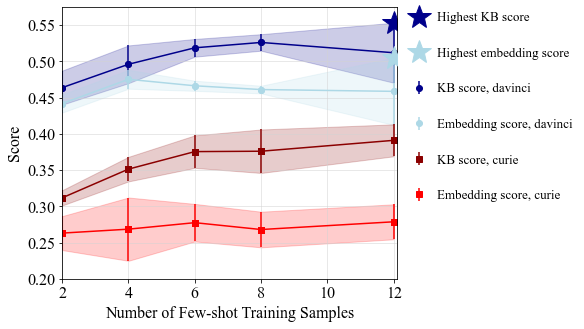

In [144]:
import matplotlib.pyplot as plt
train_samples=[2,4,6,8,12]
scores_em_davinci = [[], [], [], [], []]
scores_KB_davinci = [[], [], [], [], []]
scores_em_curie = [[], [], [], [], []]
scores_KB_curie = [[], [], [], [], []]
c1="darkblue"
c2="lightblue"
c3="darkred"
c4="red"

for run in wandb.Api().runs("YOUR_USERNAME/YOUR_PROJECT"): # replace with your username and project name
    if run.group == "gridsearch":
        amount_samples=run.config["train_samples"]
        if run.config["model"]=="text-davinci-002":
            scores_em_davinci[train_samples.index(amount_samples)].append(run.summary["mean_em"])
            scores_KB_davinci[train_samples.index(amount_samples)].append(run.summary["mean_KB"])
        elif run.config["model"]=="text-curie-001":
            scores_em_curie[train_samples.index(amount_samples)].append(run.summary["mean_em"])
            scores_KB_curie[train_samples.index(amount_samples)].append(run.summary["mean_KB"])
# plot averaged score + SD for each number of training samples
plt.figure(figsize=(6,5))
plt.errorbar([2,4,6,8,12], [np.mean(scores_KB_davinci[0]), np.mean(scores_KB_davinci[1]), np.mean(scores_KB_davinci[2]), np.mean(scores_KB_davinci[3]), np.mean(scores_KB_davinci[4])], yerr=[np.std(scores_KB_davinci[0], ddof=1), np.std(scores_KB_davinci[1], ddof=1), np.std(scores_KB_davinci[2], ddof=1), np.std(scores_KB_davinci[3], ddof=1), np.std(scores_KB_davinci[4], ddof=1)], fmt='o', label="KB score, davinci", color=c1)
plt.errorbar([2,4,6,8,12], [np.mean(scores_em_davinci[0]), np.mean(scores_em_davinci[1]), np.mean(scores_em_davinci[2]), np.mean(scores_em_davinci[3]), np.mean(scores_em_davinci[4])], yerr=[np.std(scores_em_davinci[0], ddof=1), np.std(scores_em_davinci[1], ddof=1), np.std(scores_em_davinci[2], ddof=1), np.std(scores_em_davinci[3], ddof=1), np.std(scores_em_davinci[4], ddof=1)], fmt='o', label="Embedding score, davinci", color=c2)
plt.errorbar([2,4,6,8,12], [np.mean(scores_KB_curie[0]), np.mean(scores_KB_curie[1]), np.mean(scores_KB_curie[2]), np.mean(scores_KB_curie[3]), np.mean(scores_KB_curie[4])], yerr=[np.std(scores_KB_curie[0], ddof=1), np.std(scores_KB_curie[1], ddof=1), np.std(scores_KB_curie[2], ddof=1), np.std(scores_KB_curie[3], ddof=1), np.std(scores_KB_curie[4], ddof=1)], fmt='s', label="KB score, curie", color=c3)
plt.errorbar([2,4,6,8,12], [np.mean(scores_em_curie[0]), np.mean(scores_em_curie[1]), np.mean(scores_em_curie[2]), np.mean(scores_em_curie[3]), np.mean(scores_em_curie[4])], yerr=[np.std(scores_em_curie[0], ddof=1), np.std(scores_em_curie[1], ddof=1), np.std(scores_em_curie[2], ddof=1), np.std(scores_em_curie[3], ddof=1), np.std(scores_em_curie[4], ddof=1)], fmt='s', label="Embedding score, curie", color=c4)
# make standard deviation thicker
plt.fill_between([2,4,6,8,12], [np.mean(scores_KB_davinci[0])-np.std(scores_KB_davinci[0], ddof=1), np.mean(scores_KB_davinci[1])-np.std(scores_KB_davinci[1], ddof=1), np.mean(scores_KB_davinci[2])-np.std(scores_KB_davinci[2], ddof=1), np.mean(scores_KB_davinci[3])-np.std(scores_KB_davinci[3], ddof=1), np.mean(scores_KB_davinci[4])-np.std(scores_KB_davinci[4], ddof=1)], [np.mean(scores_KB_davinci[0])+np.std(scores_KB_davinci[0], ddof=1), np.mean(scores_KB_davinci[1])+np.std(scores_KB_davinci[1], ddof=1), np.mean(scores_KB_davinci[2])+np.std(scores_KB_davinci[2], ddof=1), np.mean(scores_KB_davinci[3])+np.std(scores_KB_davinci[3], ddof=1), np.mean(scores_KB_davinci[4])+np.std(scores_KB_davinci[4], ddof=1)], alpha=0.2, color=c1)
plt.fill_between([2,4,6,8,12], [np.mean(scores_em_davinci[0])-np.std(scores_em_davinci[0], ddof=1), np.mean(scores_em_davinci[1])-np.std(scores_em_davinci[1], ddof=1), np.mean(scores_em_davinci[2])-np.std(scores_em_davinci[2], ddof=1), np.mean(scores_em_davinci[3])-np.std(scores_em_davinci[3], ddof=1), np.mean(scores_em_davinci[4])-np.std(scores_em_davinci[4], ddof=1)], [np.mean(scores_em_davinci[0])+np.std(scores_em_davinci[0], ddof=1), np.mean(scores_em_davinci[1])+np.std(scores_em_davinci[1], ddof=1), np.mean(scores_em_davinci[2])+np.std(scores_em_davinci[2], ddof=1), np.mean(scores_em_davinci[3])+np.std(scores_em_davinci[3], ddof=1), np.mean(scores_em_davinci[4])+np.std(scores_em_davinci[4], ddof=1)], alpha=0.2, color=c2)
plt.fill_between([2,4,6,8,12], [np.mean(scores_KB_curie[0])-np.std(scores_KB_curie[0], ddof=1), np.mean(scores_KB_curie[1])-np.std(scores_KB_curie[1], ddof=1), np.mean(scores_KB_curie[2])-np.std(scores_KB_curie[2], ddof=1), np.mean(scores_KB_curie[3])-np.std(scores_KB_curie[3], ddof=1), np.mean(scores_KB_curie[4])-np.std(scores_KB_curie[4], ddof=1)], [np.mean(scores_KB_curie[0])+np.std(scores_KB_curie[0], ddof=1), np.mean(scores_KB_curie[1])+np.std(scores_KB_curie[1], ddof=1), np.mean(scores_KB_curie[2])+np.std(scores_KB_curie[2], ddof=1), np.mean(scores_KB_curie[3])+np.std(scores_KB_curie[3], ddof=1), np.mean(scores_KB_curie[4])+np.std(scores_KB_curie[4], ddof=1)], alpha=0.2, color=c3)
plt.fill_between([2,4,6,8,12], [np.mean(scores_em_curie[0])-np.std(scores_em_curie[0], ddof=1), np.mean(scores_em_curie[1])-np.std(scores_em_curie[1], ddof=1), np.mean(scores_em_curie[2])-np.std(scores_em_curie[2], ddof=1), np.mean(scores_em_curie[3])-np.std(scores_em_curie[3], ddof=1), np.mean(scores_em_curie[4])-np.std(scores_em_curie[4], ddof=1)], [np.mean(scores_em_curie[0])+np.std(scores_em_curie[0], ddof=1), np.mean(scores_em_curie[1])+np.std(scores_em_curie[1], ddof=1), np.mean(scores_em_curie[2])+np.std(scores_em_curie[2], ddof=1), np.mean(scores_em_curie[3])+np.std(scores_em_curie[3], ddof=1), np.mean(scores_em_curie[4])+np.std(scores_em_curie[4], ddof=1)], alpha=0.2, color=c4)
plt.xlabel("Number of Few-shot Training Samples")
plt.ylabel("Score")
# connect error bars with lines
plt.plot([2,4,6,8,12], [np.mean(scores_KB_davinci[0]), np.mean(scores_KB_davinci[1]), np.mean(scores_KB_davinci[2]), np.mean(scores_KB_davinci[3]), np.mean(scores_KB_davinci[4])], 'o-', color=c1)
plt.plot([2,4,6,8,12], [np.mean(scores_em_davinci[0]), np.mean(scores_em_davinci[1]), np.mean(scores_em_davinci[2]), np.mean(scores_em_davinci[3]), np.mean(scores_em_davinci[4])], 'o-', color=c2)
plt.plot([2,4,6,8,12], [np.mean(scores_KB_curie[0]), np.mean(scores_KB_curie[1]), np.mean(scores_KB_curie[2]), np.mean(scores_KB_curie[3]), np.mean(scores_KB_curie[4])], 's-', color=c3)
plt.plot([2,4,6,8,12], [np.mean(scores_em_curie[0]), np.mean(scores_em_curie[1]), np.mean(scores_em_curie[2]), np.mean(scores_em_curie[3]), np.mean(scores_em_curie[4])], 's-', color=c4)



# make star for single best score and set to foreground
plt.plot([12], 0.5531443181819444, '*', color=c1, markersize=25, label="Highest KB score")
plt.plot([12], 0.5047760359942913, '*', color=c2, markersize=25, label="Highest embedding score", zorder=10)
plt.legend()
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=13, frameon=False, handletextpad=0.4, labelspacing=1.8)
# increase spacing of legend
# make y axis end at 0.6
plt.ylim(0.2, 0.575)
# make x axis end at 12
plt.xlim(2, 12.1)
# set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
# save as eps
plt.savefig('Images/scores.pdf', format='pdf', bbox_inches='tight')





# Test Set Evaluation

In [53]:
# load scores from wandb
run_configs=[]
scores_em = []
scores_KB = []
for run in wandb.Api().runs("YOUR_USERNAME/YOUR_PROJECT"): # replace with your username and project name
    scores_em.append(run.summary["mean_em"])
    scores_KB.append(run.summary["mean_KB"])
    run_configs.append(run.config)
# return config with highest average of em and KB scores
best_config = run_configs[np.argmax(np.array(scores_em)+np.array(scores_KB))]
print("Best config: ", best_config)


Best config:  {'model': 'text-davinci-002', 'eval_set': 'valid', 'extra_def': False, 'temperature': 0, 'train_indices': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, -1], 'train_samples': 12}


In [76]:
# generate completions on test set with best config from validation
df_test_results = get_GPT3_completions(best_config["train_indices"], eval_set="test", temperature=best_config['temperature'], model=best_config['model'], result_samples=999, extra_def=best_config['extra_def'])
df_LCC_results = get_GPT3_completions(best_config["train_indices"], eval_set="LCC", temperature=best_config['temperature'], model=best_config['model'], result_samples=999, extra_def=best_config['extra_def'])
df_LCC_results_es = get_GPT3_completions(best_config["train_indices"], eval_set="LCC_es", temperature=best_config['temperature'], model=best_config['model'], result_samples=999, extra_def=best_config['extra_def'])
# evaluate
mean_em, std_em, mean_KB, std_KB, df_test_results = evaluate(df_test_results)
print("Test set performance: ", str(mean_em)+"(+-"+str(std_em)+")", str(mean_KB)+"(+-"+str(std_KB)+")")
mean_em, std_em, mean_KB, std_KB, df_LCC_results = evaluate(df_LCC_results)
print("LCC set performance: ", str(mean_em)+"(+-"+str(std_em)+")", str(mean_KB)+"(+-"+str(std_KB)+")")
mean_em, std_em, mean_KB, std_KB, df_LCC_results_es = evaluate(df_LCC_results_es)
print("LCC set performance: ", str(mean_em)+"(+-"+str(std_em)+")", str(mean_KB)+"(+-"+str(std_KB)+")")
# save results to csv
df_test_results.to_csv("Test Results/Source Completion/Few Shot/best_config_test.csv")
df_LCC_results.to_csv("Test Results/Source Completion/Few Shot/best_config_LCC.csv")
df_LCC_results_es.to_csv("Test Results/Source Completion/Few Shot/best_config_LCC_es.csv")

In [165]:
annotated_test_df = pd.read_csv("Test Results/Source Completion/Few Shot/MetaphorList_annotated_test.csv", index_col=0)
annotated_LCC_df = pd.read_csv("Test Results/Source Completion/Few Shot/LCC-EN_annotated_test.csv", index_col=0 )
annotated_test_df.head()


,Target Domain,Source Domain,GPT3 Completion,Example,embedding_sim,KB_similarity,Annotator 1 (L),Comments (L),Annotator 2 (D),Comments (D),Final Annotation,Comments,Error Code,Unnamed: 14
0,intoxication,destruction,shipwreck,He was wrecked.,0.10,0.35,1,unsure (too specific),1,NaN,1,NaN,NaN,NaN
1,intoxication,destruction,violence,He got thrashed.,0.37,0.33,1,NaN,1,NaN,1,NaN,NaN,NaN
2,amount,size,breakable object,Can you break a twenty?,0.16,0.31,1,NaN,1,NaN,1,NaN,NaN,NaN
3,amount,size,size,I'm not a big eater.,1.00,1.00,1,NaN,1,NaN,1,NaN,NaN,NaN
4,beliefs,plants,seeds,I planted the belief in his mind.,0.40,0.64,1,NaN,1,NaN,1,NaN,NaN,NaN


In [166]:
# split annotated_test_df into two dataframes, one for samples where source domain is non metaphoric and the others
annotated_test_df_non_metaphoric = annotated_test_df[annotated_test_df["Source Domain"] == "not metaphoric"]
annotated_test_df_metaphoric = annotated_test_df[annotated_test_df["Source Domain"] != "not metaphoric"]


In [177]:
# compute cohen's kappa between Annotation 1 and Annotation 2
from sklearn.metrics import cohen_kappa_score
ck_non=cohen_kappa_score(annotated_test_df_non_metaphoric["Annotator 1 (L)"], annotated_test_df_non_metaphoric["Annotator 2 (D)"])
print("Cohen's kappa for non metaphoric samples: ", ck_non)
ck_met=cohen_kappa_score(annotated_test_df_metaphoric["Annotator 1 (L)"], annotated_test_df_metaphoric["Annotator 2 (D)"])
print("Cohen's kappa for Metaphor List samples: ", ck_met)
ck_LCC=cohen_kappa_score(annotated_LCC_df["Annotator 1 (L)"], annotated_LCC_df["Annotator 2 (D)"])
print("Cohen's kappa for LCC samples: ", ck_LCC)
print()

# compute agreement as percentage for non metaphoric samples
agreement_non = np.sum(annotated_test_df_non_metaphoric["Annotator 1 (L)"] == annotated_test_df_non_metaphoric["Annotator 2 (D)"])/len(annotated_test_df_non_metaphoric)
print("Agreement in percent for non metaphoric samples: ", agreement_non)
# compute agreement as percentage for metaphor list samples
agreement_met = np.sum(annotated_test_df_metaphoric["Annotator 1 (L)"] == annotated_test_df_metaphoric["Annotator 2 (D)"])/len(annotated_test_df_metaphoric)
print("Agreement in percent for Metaphor List samples: ", agreement_met)
# compute agreement as percentage for LCC samples
agreement_LCC = np.sum(annotated_LCC_df["Annotator 1 (L)"] == annotated_LCC_df["Annotator 2 (D)"])/len(annotated_LCC_df)
print("Agreement in percent for LCC samples: ", agreement_LCC)

# average agreement for all samples
print()
print("Average agreement in percent: ", (agreement_non+agreement_met+agreement_LCC)/3)
print("Average Cohen's kappa: ", (ck_non+ck_met+ck_LCC)/3)
# weighted average agreement for all samples
print()
print("Weighted average agreement in percent: ", (agreement_non*len(annotated_test_df_non_metaphoric)+agreement_met*len(annotated_test_df_metaphoric)+agreement_LCC*len(annotated_LCC_df))/(len(annotated_test_df_non_metaphoric)+len(annotated_test_df_metaphoric)+len(annotated_LCC_df)))
print("Weighted average Cohen's kappa: ", (ck_non*len(annotated_test_df_non_metaphoric)+ck_met*len(annotated_test_df_metaphoric)+ck_LCC*len(annotated_LCC_df))/(len(annotated_test_df_non_metaphoric)+len(annotated_test_df_metaphoric)+len(annotated_LCC_df)))


Cohen's kappa for non metaphoric samples:  0.8901734104046243
Cohen's kappa for Metaphor List samples:  0.5487752470992694
Cohen's kappa for LCC samples:  0.4458952423833108

Agreement in percent for non metaphoric samples:  0.9473684210526315
Agreement in percent for Metaphor List samples:  0.8755555555555555
Agreement in percent for LCC samples:  0.7253521126760564

Average agreement in percent:  0.8494253630947478
Average Cohen's kappa:  0.6282812999624015

Weighted average agreement in percent:  0.7973484848484849
Weighted average Cohen's kappa:  0.5057234360452344


In [172]:
# remove samples where annotators "Final annotation" == 2 
annotated_test_df_non_metaphoric = annotated_test_df_non_metaphoric[annotated_test_df_non_metaphoric["Final Annotation"] != 2]
annotated_test_df_metaphoric = annotated_test_df_metaphoric[annotated_test_df_metaphoric["Final Annotation"] != 2]
annotated_LCC_df = annotated_LCC_df[annotated_LCC_df["Final Annotation"] != 2]

In [175]:
# print accuracy based on final annotation
print("Accuracy based on final annotation non metaphoric: ", sum(annotated_test_df_non_metaphoric["Final Annotation"])/len(annotated_test_df_non_metaphoric))
print("Accuracy based on final annotation Metaphor List: ", sum(annotated_test_df_metaphoric["Final Annotation"])/len(annotated_test_df_metaphoric))
print("Accuracy based on final annotation LCC: ", sum(annotated_LCC_df["Final Annotation"])/len(annotated_LCC_df))

Accuracy based on final annotation non metaphoric:  0.42105263157894735
Accuracy based on final annotation Metaphor List:  0.8133333333333334
Accuracy based on final annotation LCC:  0.5373665480427047


In [176]:
# compute spearman correlation between KB score and final annotation
from scipy.stats import spearmanr
sp_non_met=spearmanr(annotated_test_df_non_metaphoric["KB_similarity"], annotated_test_df_non_metaphoric["Final Annotation"])
sp_MetList=spearmanr(annotated_test_df_metaphoric["KB_similarity"], annotated_test_df_metaphoric["Final Annotation"])
print("Spearman correlation KB non metaphoric: ", sp_non_met)
print("Spearman correlation KB Metaphor List: ", sp_MetList)
# same for embedding_sim
sp_non_met=spearmanr(annotated_test_df_non_metaphoric["embedding_sim"], annotated_test_df_non_metaphoric["Final Annotation"])
sp_MetList=spearmanr(annotated_test_df_metaphoric["embedding_sim"], annotated_test_df_metaphoric["Final Annotation"])
print("Spearman correlation EM non metaphoric: ", sp_non_met)
print("Spearman correlation EM Metaphor List: ", sp_MetList)

# merge annotated_test_df_non_metaphoric and annotated_test_df_metaphoric and compute spearman correlation between KB score and final annotation
annotated_test_df_all = pd.concat([annotated_test_df_non_metaphoric, annotated_test_df_metaphoric])
sp_all=spearmanr(annotated_test_df_all["KB_similarity"], annotated_test_df_all["Final Annotation"])
print("Spearman correlation KB all: ", sp_all)
# same for embedding_sim
sp_all=spearmanr(annotated_test_df_all["embedding_sim"], annotated_test_df_all["Final Annotation"])
print("Spearman correlation EM all: ", sp_all)


Spearman correlation KB non metaphoric:  SpearmanrResult(correlation=0.8955910525085282, pvalue=2.202100379409556e-07)
Spearman correlation KB Metaphor List:  SpearmanrResult(correlation=0.34432716202421004, pvalue=1.1639251248950027e-07)
Spearman correlation EM non metaphoric:  SpearmanrResult(correlation=0.8802224000709448, pvalue=6.703159561855441e-07)
Spearman correlation EM Metaphor List:  SpearmanrResult(correlation=0.3864533413655767, pvalue=1.9827552286916033e-09)
Spearman correlation KB all:  SpearmanrResult(correlation=0.4319537445637061, pvalue=1.6388503310107196e-12)
Spearman correlation EM all:  SpearmanrResult(correlation=0.40255186337112375, pvalue=6.390186126270552e-11)


# Finetuning

In [129]:
def create_finetuning_dataset(raw_prompts, raw_completions, name):
    prompts = []
    completions = []
    for i in range(len(raw_prompts)):
        prompts.append(raw_prompts[i][71:])
        completions.append(" "+raw_completions[i]+" END")
    df = pd.DataFrame({'prompt': prompts, 'completion': completions})
    df.to_csv(name, index=False)

create_finetuning_dataset(list_of_source_prompts_train, list_of_source_completions_train, "Finetuning Data/source-finetuning-train.csv")
create_finetuning_dataset(list_of_source_prompts_test, list_of_source_completions_test, "Finetuning Data/source-finetuning-test.csv")
create_finetuning_dataset(list_of_source_prompts_valid, list_of_source_completions_valid, "Finetuning Data/source-finetuning-valid.csv")

In [136]:
# have only one train example from list_of_source_completions_train per unique completion
unique_completions = []
unique_prompts = []
for i in range(len(list_of_source_completions_train)):
    if list_of_source_completions_train[i] not in unique_completions:
        unique_completions.append(list_of_source_completions_train[i])
        unique_prompts.append(list_of_source_prompts_train[i])
create_finetuning_dataset(unique_prompts, unique_completions, "Finetuning Data/source-finetuning-train-unique.csv")
        


In [138]:
print(len(unique_prompts), len(list_of_source_completions_train))

34 132


To create the required json files for finetuning run the following command in the console:

    openai tools fine_tunes.prepare_data -f <LOCAL_FILE.csv>

Afterwards create finetuned model with:

    export OPENAI_API_KEY=<YOUR_API_KEY>

    openai api fine_tunes.create -t <TRAIN_FILE_ID_OR_PATH> -m davinci --suffix "<name>"

In [105]:
def get_GPT3_completions_finetune(test, temperature, model, result_samples):
    if test:
        data=pd.read_csv("Finetuning Data/source-finetuning-test.csv")
    else:
        data=pd.read_csv("Finetuning Data/source-finetuning-valid.csv")
    
    prompts = data['prompt']
    completions = data['completion']

    GPT3_completions=[]
    for p in prompts[:result_samples]:
        c = openai.Completion.create(
                model=model,
                prompt=p,
                max_tokens=14,
                temperature=temperature,
                stop=[" END"]

            )
        GPT3_completions.append(c)
        # wait to avoid rate limit
        time.sleep(3)

    df_results = data.copy().reset_index()

    # append GPT3_completions to df_results [trainings_units:len(GPT3_completions)]
    for i in range(len(GPT3_completions)):
        gpt3_completion = GPT3_completions[i].choices[0].text
        # strip everything after the first newline
        #gpt3_completion = gpt3_completion.split("\n")[0]
        df_results.loc[i, 'GPT3 Completion'] = gpt3_completion
    return df_results[:len(GPT3_completions)]

In [ ]:
model = "YOUR_FINETUNED_MODEL_NAME" # you will receive this name after finetuning as described above 

temperature=0
result_samples=999
test=False
if "unique" in model:
    train_samples = 34
else:
    train_samples = 132

run_name="Finetuned_temp-"+str(temperature)+model
if test:
    run_name=run_name+"_test"
else:
    run_name=run_name+"_valid"


df_results = get_GPT3_completions_finetune(test, temperature, model, result_samples)




# evaluate
mean_em, std_em, mean_KB, std_KB, df_results = evaluate(df_results, "Finetuned")
print("Performance: ", str(mean_em)+"(+-"+str(std_em)+")", str(mean_KB)+"(+-"+str(std_KB)+")")
run_name=run_name+"_em-"+str(round(mean_em,3))+"_KB-"+str(round(mean_KB,3))

config={
    "model": model,
    "temperature": temperature,
    "train_indices": "finetuned",
    "train_samples": train_samples,
    "extra_def": False,
    "eval_set": "valid",
}

run_name.replace("/", "-")

with wandb.init(project="Metaphors", config=config, group="finetuned"):
    wandb.log({"mean_em": mean_em, "std_em": std_em, "mean_KB": mean_KB, "std_KB": std_KB})

df_results.to_csv("Validation Results/Source Completion/Finetuned/"+run_name+".csv")
df_results

In [133]:
# look at diversity of completions
print("unique source domains")
df_results_finetuneunique = pd.read_csv("Validation Results/Source Completion/Finetuned/Finetuned_temp-0davinci-ft-personal-unique34samples-2022-10-30-12-23-49_valid_em-0.303_KB-0.386.csv")
print("unique:", len(df_results_finetuneunique["GPT3 Completion"].unique()))
df_results_finetunefull = pd.read_csv("Validation Results/Source Completion/Finetuned/Finetuned_temp-0davinci-ft-personal-fulltrain-2022-11-03-15-21-24_valid_em-0.413_KB-0.513.csv")
print("full:", len(df_results_finetunefull["GPT3 Completion"].unique()))
df_results_best = pd.read_csv("Validation Results/Source Completion/Few Shot/valid_davinci-002_temp-0_[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, -1]_(12-train-samples)_def-False_embscore-5_KBscore-55.csv")
print("best:", len(df_results_best["GPT3 Completion"].unique()))
# overlap between GPT3 completions of finetuned models and train_df "Source Domain"
predicted_domains_full = set(df_results_finetunefull["GPT3 Completion"])
predicted_domains_unique = set(df_results_finetuneunique["GPT3 Completion"])
predicted_domains_best = set(df_results_best["GPT3 Completion"])
# remove END token
predicted_domains_full = set([x.replace(" END", "").strip() for x in predicted_domains_full])
predicted_domains_unique = set([x.replace(" END", "").strip() for x in predicted_domains_unique])
predicted_domains_best = set([x.replace(" END", "").strip() for x in predicted_domains_best])
print("overlap with train")
print("unique:", len(predicted_domains_unique.intersection(set(train_df["Source Domain"]))))
print("full:", len(predicted_domains_full.intersection(set(train_df["Source Domain"]))))
print("best:", len(predicted_domains_best.intersection(set(train_df["Source Domain"]))))



unique source domains
unique: 78
full: 50
best: 74
overlap with train
unique: 13
full: 18
best: 7


In [132]:
predicted_domains_full

{'advantage',
 'adversary',
 'age',
 'alive',
 'animal',
 'balloon',
 'beings',
 'belief',
 'bottom',
 'center',
 'clarity',
 'commodities',
 'competition',
 'container',
 'darkness',
 'defeat',
 'end',
 'energy',
 'existence',
 'flow',
 'force',
 'heat',
 'injury',
 'interpretation',
 'length',
 'light',
 'line',
 'machines',
 'money',
 'motion',
 'not metaphoric',
 'palm',
 'part-whole',
 'path',
 'possessions',
 'predators',
 'pull',
 'scale',
 'sight',
 'size',
 'space',
 'speech',
 'stability',
 'substance',
 'sum',
 'thirst',
 'time',
 'weapons',
 'weight',
 'wheel'}

# Model Application Example

In [109]:
from datasets import load_dataset
text_dataset = load_dataset("SocialGrep/the-reddit-covid-dataset", "posts")

Extracting data files: 100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


Dataset the-reddit-covid-dataset downloaded and prepared to /Users/lennartwachowiak/.cache/huggingface/datasets/SocialGrep___the-reddit-covid-dataset/posts/1.0.0/35698a78e6ebe9f3da4d0d354139c89d8097b4498816cab987639ad00dbe4a92. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


In [130]:
sentences_to_analyse=[]
for sentence in text_dataset["train"]["title"][0:10000]:
    if "restriction" in sentence:
        sentences_to_analyse.append(sentence)
        #print(sentence)
    

In [121]:
# remove duplicates from sentences_to_analyse
sentences_to_analyse = list(set(sentences_to_analyse))
print(len(sentences_to_analyse))

128


In [159]:
def create_long_prompt_new_text(list_of_prompts, list_of_completions, start_index, end_index, query_text, query_target):
    prompt=""
    for j in range(start_index, end_index):
        prompt+=list_of_prompts[j]+list_of_completions[j]+"\n"
    prompt+="Extract the conceptual metaphor from the following sentence:\nSentence: "
    prompt+=query_text
    prompt+="\nTarget Domain: "+query_target
    prompt+="\nSource Domain:"
    return prompt

In [160]:
analysis_prompts = []
for s in sentences_to_analyse:
    analysis_prompts.append(create_long_prompt_new_text(list_of_source_prompts, list_of_source_completions, 0, trainings_units, s, "restriction"))

In [161]:
print(analysis_prompts[0])

Extract the conceptual metaphor from the following sentence:
Sentence: She spends her time unwisely.
Target Domain: time
Source Domain:money
Extract the conceptual metaphor from the following sentence:
Sentence: Even small magnets are sources of magnetism that can erase credit cards.
Target Domain: force
Source Domain:object, mover
Extract the conceptual metaphor from the following sentence:
Sentence: I'm all charged up and full of energy
Target Domain: people
Source Domain:batteries
Extract the conceptual metaphor from the following sentence:
Sentence: He turned all funny.
Target Domain: change
Source Domain:direction, motion, movement
Extract the conceptual metaphor from the following sentence:
Sentence: Daughter broke Covid restrictions against the rules of the house
Target Domain: restriction
Source Domain:


In [162]:
GPT3_analysis_completions=[]
for p in analysis_prompts[:10]:
    c = openai.Completion.create(
            model="text-davinci-002",
            prompt=p,
            max_tokens=14,
            temperature=0
        )
    GPT3_analysis_completions.append(c)

In [164]:
for i in range(len(GPT3_analysis_completions)):
    print(sentences_to_analyse[i])
    print("Predicted Source Domain:", GPT3_analysis_completions[i].choices[0].text)
    print()

Daughter broke Covid restrictions against the rules of the house
Predicted Source Domain: prison

Farmers Mother of all protests still going ahead next month despite Covid-19 restrictions
Predicted Source Domain: containment, enclosure

Illinois trying to legislate Covid restrictions... ?
Predicted Source Domain:  law

@Reuters: Biden issuing new order lifting COVID-19 travel restrictions, imposing vaccine rules https://t.co/pZogUEwyLV https://t.co/EoRYNpqFlr
Predicted Source Domain:  travel

COVID restrictions in Prague?
Predicted Source Domain: prison

Parents, has covid restrictions added more or less pressure on you to be a Super Parent?
Predicted Source Domain: weight, pressure

Advice for friend circumventing COVID restrictions
Predicted Source Domain: obstacle, blockage

[World] - Slovakia extends COVID-19 restrictions amid infection surge | Toronto Star
Predicted Source Domain: containment

[World] - Slovakia extends COVID-19 restrictions amid infection surge
Predicted Source D